In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost

from functions import make_dataset

from functions import make_portfolio

from sklearn.utils import shuffle

import time

import pickle

In [6]:
features2 = pd.read_pickle("training_sets/features2")

In [7]:
Date1 = np.load("training_sets/Date1.npy", allow_pickle = True)
Date2 = np.load("training_sets/Date2.npy", allow_pickle = True)
Date3 = np.load("training_sets/Date3.npy", allow_pickle = True)

In [8]:
Dates = np.append(np.append(Date1, Date2), Date3)

In [37]:
prediction_dates = np.linspace(800, len(Dates) - 150, 10).astype(int)

In [38]:
prediction_dates

array([ 800,  954, 1108, 1262, 1416, 1570, 1724, 1878, 2032, 2187])

In [11]:
columns_to_choose_from = features2.columns[:-11]

In [35]:
cols_trials = []
for i in range(10):
    cols_trials.append(np.random.choice(columns_to_choose_from, 18, replace = False))
    


In [13]:
def make_dataset_eval_with_extra_return_40_term_from_periods(df, training_period, prediction_period, cols, pred_col, return_col):
    
    
    X_train = shuffle(df.loc[training_period, np.append(cols, pred_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)
    
    
    
    X_test = shuffle(df.loc[prediction_period, np.append(np.append(cols, pred_col), return_col)])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    Y_test = X_test.pop(pred_col)
    Y_return_40 = X_test.pop(return_col)
    
    return X_train, X_test, Y_train, Y_test, Y_return_40

In [86]:
def make_dataset_eval_with_extra_return_40_term_from_periods_for_regression(df, training_period, prediction_period, cols, pred_col, return_col):
    
    
    X_train = shuffle(df.loc[training_period, np.append(np.append(cols, pred_col), return_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)
    Y_return_40_train = X_train.pop(return_col)
    
    
    
    X_test = shuffle(df.loc[prediction_period, np.append(np.append(cols, pred_col), return_col)])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    Y_test = X_test.pop(pred_col)
    Y_return_40_test = X_test.pop(return_col)
    
    return X_train, X_test, Y_train, Y_test, Y_return_40_train, Y_return_40_test

In [14]:
def return_40_metric(pred, labels):


    return np.mean(labels[np.argsort(pred)[:500]]), (1-np.sort(pred)[499]), np.mean(labels[np.argsort(pred)[:100]]), (1-np.sort(pred)[99]), np.mean(labels[np.argsort(pred)[:20]]), (1-np.sort(pred)[19])

In [89]:
def return_40_metric_for_regression(pred, labels):


    return np.mean(labels[np.argsort(pred)[::-1][:500]]), np.sort(pred)[-500], np.mean(labels[np.argsort(pred)[::-1][:100]]), np.sort(pred)[-99], np.mean(labels[np.argsort(pred)[::-1][:20]]), np.sort(pred)[-19]

In [90]:
class my_callback_regression(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        
        
    def after_iteration(self, model, epoch, evals_log):
            
            
        if not epoch %10:

            print(epoch)

        predictions_eval = model.predict(self.eval_mine)

        self.results_eval_mine.append(return_40_metric_for_regression(model.predict(self.eval_mine), self.eval_return_40))    
        
                   
        return False

In [15]:
class my_callback(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        
        
    def after_iteration(self, model, epoch, evals_log):
            
            
        if not epoch %10:

            print(epoch)

        predictions_eval = model.predict(self.eval_mine)

        self.results_eval_mine.append(return_40_metric(model.predict(self.eval_mine), self.eval_return_40))    
        
                 
            
        return False

In [16]:
class my_callback2(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgtrain):
        self.dtrain_mine = xgtrain
        pass
        
        
    def before_iteration(self, model, epoch, evals_list):
        
        print(epoch)
        
        predictions = model.predict(self.dtrain_mine)
        labels = self.dtrain_mine.get_label()
        weights = np.ones(len(labels))
        threshold_5 = np.percentile(predictions, 5)
        
        weights[np.where((labels == 1) & (predictions < threshold_5))[0]] = 100
        weights[np.where((labels == 0) & (predictions >= threshold_5))[0]] = 19

        
        
        xgtrain.set_weight(weights)
    
        return False

In [32]:
class my_callback3(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval, xgtrain, type_num):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        self.dtrain_mine = xgtrain
        self.type_num = type_num
        
    def after_iteration(self, model, epoch, evals_log):
            
            
        if not epoch %10:

            print(epoch)

        predictions_eval = model.predict(self.eval_mine)

        self.results_eval_mine.append(return_40_metric(model.predict(self.eval_mine), self.eval_return_40))    
        
                 
            
        return False
    
    
    def before_iteration(self, model, epoch, evals_list):
        
        if self.type_num == 2:
        

            predictions = model.predict(self.dtrain_mine)
            labels = self.dtrain_mine.get_label()
            weights = np.ones(len(labels))
            threshold_5 = np.percentile(predictions, 5)

            weights[np.where((labels == 1) & (predictions < threshold_5))[0]] = 30
            weights[np.where(labels == 0)[0]] = 19
            


            xgtrain.set_weight(weights)
            
        
    
        return False
    
    

In [33]:
class my_callback4(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval, xgtrain, type_num):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        self.dtrain_mine = xgtrain
        self.type_num = type_num
        
    def after_iteration(self, model, epoch, evals_log):
            
            
        if not epoch %10:

            print(epoch)

        predictions_eval = model.predict(self.eval_mine)

        self.results_eval_mine.append(return_40_metric(model.predict(self.eval_mine), self.eval_return_40))    
        
                 
            
        return False
    
    
    def before_iteration(self, model, epoch, evals_list):
        
        if self.type_num == 2:
        

            predictions = model.predict(self.dtrain_mine)
            labels = self.dtrain_mine.get_label()
            weights = np.ones(len(labels))
            threshold_5 = np.percentile(predictions, 0.5)

            weights[np.where((labels == 1) & (predictions < threshold_5))[0]] = 30
            weights[np.where(labels == 0)[0]] = 19
            

            xgtrain.set_weight(weights)
            
        
    
        return False

In [31]:
0.5 / 100 * 20000

100.0

In [18]:
params1 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}

In [26]:
with open("CustomLoss/OgVsDynamicWeights.pkl", "rb") as f:
    results = pickle.load(f)
    

In [29]:
cols_trials = []
for i in range(10):
    cols_trials.append(results[0][i][1])

In [51]:
prediction_date = 400

In [59]:
training_period = Date2[prediction_date - 200 - 40 + 1: prediction_date - 40 +1]

prediction_period = Date2[prediction_date :prediction_date + 20 + 1]

In [60]:
features2 = pd.read_pickle("training_sets/features2")

In [61]:
cols

array(['Retained Earnings/Total Liabilities_YC', 'Working Capital',
       'Total Current Assets/Total Assets_QC', 'WillR_80',
       'Retained Earnings/Total Liabilities_QC', 'OBV_80',
       'Net Cash from Operating Activities/Cash & Cash Equivalents_YC',
       'MFV_40_10_indicator_sign_change', 'volatility_160',
       'Price to Free Cash Flow (quarterly)_YC', 'close_0/Close_200',
       'Net Cash from Operating Activities/Cash & Cash Equivalents_QC',
       'APO_10_40', 'Share Capital & Additional Paid-In Capital_QC',
       'Payables & Accruals/Cost of Revenue_YC', 'DEMA_40',
       'Cash from (Repayment of) Debt/Total Liabilities', 'volstd_160'],
      dtype=object)

In [64]:
X_train, X_test, Y_train, Y_test, Y_return_40_train, Y_return_40_test = make_dataset_eval_with_extra_return_40_term_from_periods(features2, training_period, prediction_period, cols, "Class_binary_40_20", "return_40")

In [65]:
xgtrain = xgboost.DMatrix(X_train.values, Y_return_40_train.values)
xgtest = xgboost.DMatrix(X_test.values, Y_return_40_test.values)

In [79]:
a = []
mycallback_regression = my_callback_regression(xgtest, Y_return_40_test, a)


In [80]:
start_time = time.perf_counter()

bst = xgboost.train(params = params3, dtrain = xgtrain, evals = [(xgtest, "eval")], num_boost_round = 20, callbacks = [mycallback_regression])

print(time.perf_counter() - start_time)

[0]	eval-rmse:18.18925
0
[1]	eval-rmse:18.09711
[2]	eval-rmse:18.03845
[3]	eval-rmse:18.00669
[4]	eval-rmse:17.98633
[5]	eval-rmse:17.97643
[6]	eval-rmse:17.97759
[7]	eval-rmse:17.97940
[8]	eval-rmse:17.98449
[9]	eval-rmse:17.98911
[10]	eval-rmse:17.99404
10
[11]	eval-rmse:17.99855
[12]	eval-rmse:18.00494
[13]	eval-rmse:18.01195
[14]	eval-rmse:18.02157
[15]	eval-rmse:18.03102
[16]	eval-rmse:18.04022
[17]	eval-rmse:18.04826
[18]	eval-rmse:18.05953
[19]	eval-rmse:18.06769
3.8388931000008597


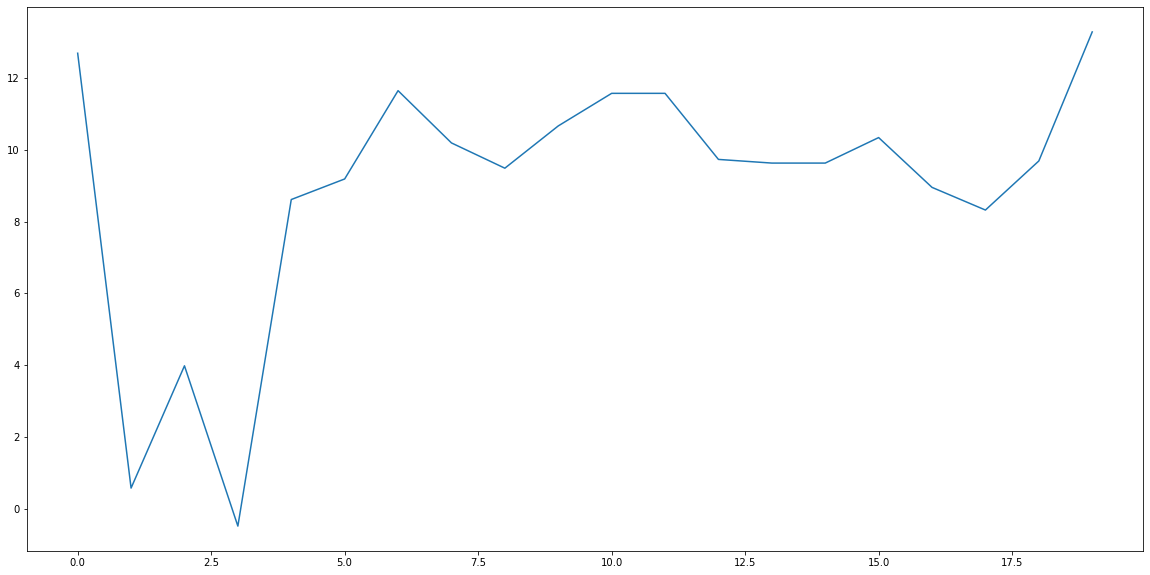

In [85]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(a)[:,4])

In [72]:
predt = bst.predict(xgtest)

In [75]:
np.sort(predt)[::-1][:100]

array([23.14309  , 23.109585 , 23.007439 , 22.987679 , 22.531878 ,
       22.496904 , 21.943472 , 20.756687 , 20.742535 , 20.686825 ,
       20.364836 , 20.14024  , 20.084316 , 20.038412 , 19.685009 ,
       19.663052 , 18.935762 , 18.329271 , 17.428532 , 17.09323  ,
       16.851234 , 16.40382  , 16.382832 , 15.903527 , 15.892105 ,
       15.340439 , 15.258118 , 13.688879 , 13.442756 , 13.442756 ,
       13.393919 , 13.29779  , 13.15687  , 13.150453 , 13.04587  ,
       12.885432 , 12.875176 , 12.849975 , 12.825132 , 12.787042 ,
       12.782911 , 12.761277 , 12.717521 , 12.674723 , 12.622698 ,
       12.595027 , 12.589171 , 12.537284 , 12.536763 , 12.4512   ,
       12.416455 , 12.416455 , 12.382054 , 12.32036  , 12.293811 ,
       12.241127 , 12.230056 , 12.214984 , 12.166492 , 12.071576 ,
       12.043937 , 12.025856 , 12.02284  , 12.021659 , 12.019185 ,
       12.017846 , 12.010446 , 12.003912 , 11.988014 , 11.975936 ,
       11.945688 , 11.923316 , 11.9001   , 11.88576  , 11.8843

In [68]:
params3 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'reg:squarederror',
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}


In [91]:
results = []

for prediction_date in prediction_dates:
    
    results1 = []
    
    
    for indx, cols in enumerate(cols_trials):
        results2 = []
        
        unique_cols = np.append(cols, ["Class_binary_40_20", "return_40"])
        
        start_time_df_create = time.perf_counter()
        
        
        training_period = Dates[prediction_date - 200 - 40 + 1: prediction_date - 40 +1]

        prediction_period = Dates[prediction_date :prediction_date + 20 + 1]
        
        
        if len(np.intersect1d(np.append(training_period, prediction_period), Date1)):
        
            if "features1" not in locals():

                features1 = pd.read_pickle("training_sets/features1")   
                
                print("imported features1")

            Date1_intersect = np.intersect1d(np.append(training_period, prediction_period), Date1)

            X_train_master = features1.loc[Date1_intersect, unique_cols]
            

        else:

            if "features1" in locals():
                del features1
                
                print("deleted features1")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date2)):
            
            if "features2" not in locals():

                features2 = pd.read_pickle("training_sets/features2")
                
                print("imported features2")
                
            Date2_intersect = np.intersect1d(np.append(training_period, prediction_period), Date2)
                
            if "X_train_master" in locals():
                
                X_train_master = X_train_master.append(features2.loc[Date2_intersect, unique_cols])
                
            else:
                
                X_train_master = features2.loc[Date2_intersect, unique_cols]
                
        else:

            if "features2" in locals():
                del features2
                
                print("deleted features2")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date3)):

            if "features3" not in locals():

                features3 = pd.read_pickle("training_sets/features3")
                
                print("imported features3")
                
                
            Date3_intersect = np.intersect1d(np.append(training_period, prediction_period), Date3)
                
            if "X_train_master" in locals():
                
                X_train_master = X_train_master.append(features3.loc[Date3_intersect, unique_cols])
                
            else:
                
                X_train_master = features3.loc[Date3_intersect, unique_cols]

        else:

            if "features3" in locals():
                del features3
                
                print("deleted features3")
                
                
        print("df_create_time: "+ str(time.perf_counter() - start_time_df_create))
    
        
        
        X_train, X_test, Y_train, Y_test, Y_return_40_train, Y_return_40_test = make_dataset_eval_with_extra_return_40_term_from_periods_for_regression(X_train_master, training_period, prediction_period, cols, "Class_binary_40_20", "return_40")

        train_weights = Y_train.map({0:19, 1:1})

        xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols, weight = train_weights)
        
        xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)
        
        data = []

        mycallback = my_callback3(xgtest, Y_return_40_test, data, xgtrain, 1)

        start_time_train_og = time.perf_counter()
        bst = xgboost.train(params1, xgtrain, num_boost_round = 20, verbose_eval = False, callbacks = [mycallback])
        print("og: " + str(time.perf_counter() - start_time_train_og ))
        
        xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols)
        xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)
        
        data3 = []
        
        mycallback3 = my_callback3(xgtest, Y_return_40_test, data3, xgtrain, 2)
        
        start_time_train_new = time.perf_counter()
        bst = xgboost.train(params1, xgtrain, num_boost_round = 20, verbose_eval = False, callbacks = [mycallback3])
        print("new: " + str(time.perf_counter() - start_time_train_new ))
        
        data4 = []
        
        xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols)
        xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)
        
        mycallback4 = my_callback4(xgtest, Y_return_40_test, data4, xgtrain, 2)
        
        
        start_time_train_new = time.perf_counter()
        bst = xgboost.train(params1, xgtrain, num_boost_round = 20, verbose_eval = False, callbacks = [mycallback4])
        print("new: " + str(time.perf_counter() - start_time_train_new ))
        
        data_regression = []
        
        xgtrain = xgboost.DMatrix(X_train.values, Y_return_40_train.values, feature_names = cols)
        xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)  
        
        mycallback_regression = my_callback_regression(xgtest, Y_return_40_test, data_regression)
        
        
        start_time_train_new = time.perf_counter()
        bst = xgboost.train(params = params3, dtrain = xgtrain, num_boost_round = 20, callbacks = [mycallback_regression])
        print("regression: " + str(time.perf_counter() - start_time_train_new ))
    
        
        results2.append(Dates[prediction_date])
        results2.append(cols)
        results2.append(data)
        results2.append(data3)
        results2.append(data4)
        results2.append(data_regression)
        
        results1.append(results2)

            
        del X_train_master
        
        
    results.append(results1)
    
    with open('CustomLoss/OgVsDynamicWeights3.pkl', 'wb') as f:
        pickle.dump(results, f)
            


df_create_time: 0.4609803999992437
0
10
og: 3.708164100000431
0
10
new: 3.8111723000001803
0
10
new: 3.7729537000013806
0
10
regression: 3.677992799999629
df_create_time: 0.4588036999994074
0
10
og: 3.651873999999225
0
10
new: 3.727059900000313
0
10
new: 3.7263658000010764
0
10
regression: 3.5576690999987477
df_create_time: 0.4381522000003315
0
10
og: 4.009063800000149
0
10
new: 4.0625270000018645
0
10
new: 3.990574999999808
0
10
regression: 3.8372324999982084
df_create_time: 0.4533441000021412
0
10
og: 3.9706053999980213
0
10
new: 4.116181500001403
0
10
new: 4.0586971000011545
0
10
regression: 3.9106238999993366
df_create_time: 0.46290919999955804
0
10
og: 4.059599299998808
0
10
new: 4.147135799998068
0
10
new: 4.1869992000029015
0
10
regression: 4.019300800002384
df_create_time: 0.43782590000046184
0
10
og: 3.907388000003266
0
10
new: 4.062376900001254
0
10
new: 4.0479857999998785
0
10
regression: 3.8328618000014103
df_create_time: 0.4601793000001635
0
10
og: 3.899715899999137
0
10
n

In [2]:
with open("CustomLoss/OgVsDynamicWeights3.pkl", "rb") as f:
    results = pickle.load(f)

In [47]:
np.array(results[0][0][4])[:,4]


array([ 62.70016357,  43.05651728,  14.93706654,   5.87715699,
       -21.56004715,   9.40562165, -18.17770351,  18.42216496,
         7.34247803,  15.15984564,  17.9685122 ,  39.51180653,
        35.62512326,  32.44398419,  31.61577709,  34.77901854,
        18.55567186,  34.77901854,  28.04510209,  32.47582098])

In [3]:
og = []
new = []
new2 = []
reg = []
for pred_date in range(10):
    for col_indx in range(10):
        
        og.append(np.array(results[pred_date][col_indx][2])[:,4])
        new.append(np.array(results[pred_date][col_indx][3])[:,4])
        new2.append(np.array(results[pred_date][col_indx][4])[:,4])
        reg.append(np.array(results[pred_date][col_indx][5])[:,4])
        

In [4]:
np.shape(og)

(100, 20)

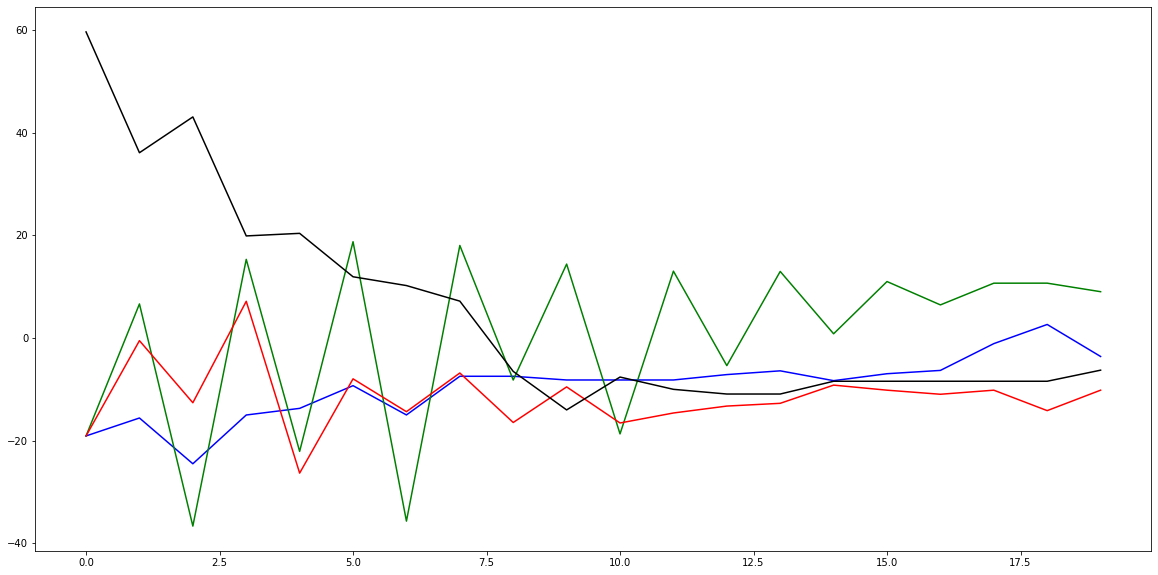

In [19]:
plt.figure(figsize = (20,10))
num = -14
plt.plot(og[num], "blue")
plt.plot(new[num], "green")
plt.plot(new2[num], "red")
plt.plot(reg[num], "black")

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(np.std(og, axis = 0), "b")
plt.plot(np.std(new, axis = 0), "g")
plt.plot(np.std(new2, axis = 0), "r")
plt.plot(np.std(reg, axis = 0), "black")

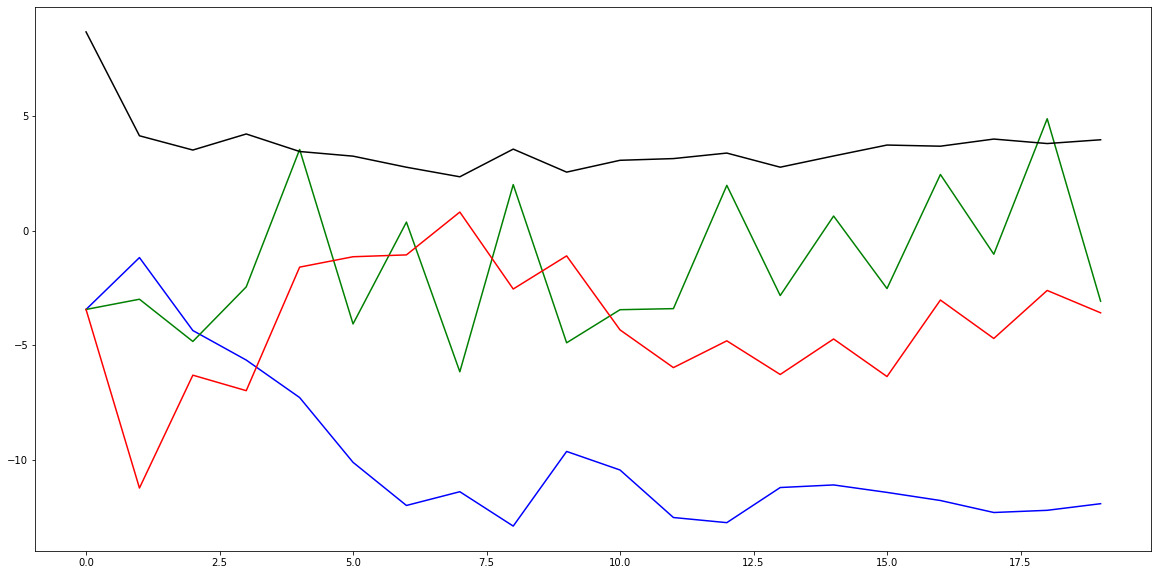

In [20]:
plt.figure(figsize = (20, 10))
plt.plot(np.mean(og[-30:], axis = 0), "b")
plt.plot(np.mean(new[-30:], axis = 0), "g")
plt.plot(np.mean(new2[-30:], axis = 0), "r")
plt.plot(np.mean(reg[-30:], axis = 0), "black")

In [ ]:
prediction_dates

In [6]:
prediction_date = 400

In [112]:
cols = np.random.choice(features1.columns[:-11], 18, replace = False)

In [113]:
X_train, X_test, Y_train, Y_test, Y_return_40 = make_dataset_eval_with_extra_return_40_term(features2, 200, 40, 20, 450, Date2, cols, "Class_binary_40_20")

In [41]:
len(X_train)

244318

In [40]:
len(Y_train)

244318

In [10]:
len(cols), len(np.unique(cols))

(18, 18)

In [192]:

            
xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols)
xgtest = xgboost.DMatrix(X_test.values, Y_test.values, feature_names = cols)

In [171]:
xgtrain2 = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols)
xgtest2 = xgboost.DMatrix(X_test.values, Y_test.values, feature_names = cols)

In [108]:
train_weights = Y_train.map({0:19, 1:1})

In [110]:
xgtrain.set_weight(train_weights)

In [44]:
train_weights = Y_train.map({0:19, 1:1})
            
xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols, weight = train_weights)
xgtest = xgboost.DMatrix(X_test.values, Y_test.values feature_names = cols)

SyntaxError: invalid syntax (<ipython-input-44-defd57b6f8e0>, line 4)

In [ ]:
"""
try to penalise it exponentially for classifiying one as 0 (false positive)

"""

In [42]:
Y_train

Date        Ticker
2016-03-09  JAKK      1.0
2016-05-09  NWY       1.0
2015-12-02  AGNC      1.0
2016-05-31  CMG       1.0
2016-07-13  NATR      1.0
                     ... 
2016-06-20  AEHR      1.0
2016-06-09  COMM      1.0
2016-04-29  AAL       1.0
2016-02-09  RAI       1.0
2016-03-04  MNK       1.0
Name: Class_binary_40_20, Length: 244318, dtype: float64

In [ ]:
"""
basically i cant seem to get the binary log objective function working, but it doesent matter because i found a hack
create a callback that adjusts the weights of the train dmatrix before each iteration
even though the callback is not passed the dmatrix object, we seemingly still can edit the weights and this is proven because there is diff performance using the callback and without it

the script for assigning weights:
predictions = model.predict(self.dtrain_mine)
labels = self.dtrain_mine.get_label()
weights = np.ones(len(labels))
threshold_5 = np.percentile(predictions, 5)

weights[np.where((labels == 1) & (predictions < threshold_5))[0]] = 100
weights[np.where((labels == 0) & (predictions >= threshold_5))[0]] = 19

xgtrain.set_weight(weights)

"""

In [188]:
c = []

In [189]:
def test2():
    c.append("1")

In [190]:
def test(c):
    for i in range(10):
        test2()
        print(c)


In [191]:
test(c)

['1']
['1', '1']
['1', '1', '1']
['1', '1', '1', '1']
['1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


In [173]:
mycallback = my_callback(xgtrain)

In [167]:
a = {}

In [193]:
bst = xgboost.train(params = params1, dtrain= xgtrain, num_boost_round = 20, evals = [(xgtest, "eval_logloss")], evals_result = a, callbacks = [mycallback])

0
[0]	eval_logloss-logloss:0.61928
1
[1]	eval_logloss-logloss:0.50834
2
[2]	eval_logloss-logloss:0.39681
3
[3]	eval_logloss-logloss:0.36501
4
[4]	eval_logloss-logloss:0.31248
5
[5]	eval_logloss-logloss:0.30038
6
[6]	eval_logloss-logloss:0.28731
7
[7]	eval_logloss-logloss:0.30282
8
[8]	eval_logloss-logloss:0.28103
9
[9]	eval_logloss-logloss:0.29365
10
[10]	eval_logloss-logloss:0.27905
11
[11]	eval_logloss-logloss:0.29834
12
[12]	eval_logloss-logloss:0.27696
13
[13]	eval_logloss-logloss:0.29112
14
[14]	eval_logloss-logloss:0.26456
15
[15]	eval_logloss-logloss:0.27471
16
[16]	eval_logloss-logloss:0.25347
17
[17]	eval_logloss-logloss:0.28140
18
[18]	eval_logloss-logloss:0.26024
19
[19]	eval_logloss-logloss:0.26475


In [176]:
bst = xgboost.train(params = params1, dtrain= xgtrain2, num_boost_round = 20, evals = [(xgtest, "eval_logloss")], evals_result = a)

[0]	eval_logloss-logloss:0.47714
[1]	eval_logloss-logloss:0.36010
[2]	eval_logloss-logloss:0.28912
[3]	eval_logloss-logloss:0.24401
[4]	eval_logloss-logloss:0.21465
[5]	eval_logloss-logloss:0.19557
[6]	eval_logloss-logloss:0.18300
[7]	eval_logloss-logloss:0.17478
[8]	eval_logloss-logloss:0.16934
[9]	eval_logloss-logloss:0.16587
[10]	eval_logloss-logloss:0.16346
[11]	eval_logloss-logloss:0.16172
[12]	eval_logloss-logloss:0.16044
[13]	eval_logloss-logloss:0.15939
[14]	eval_logloss-logloss:0.15851
[15]	eval_logloss-logloss:0.15785
[16]	eval_logloss-logloss:0.15726
[17]	eval_logloss-logloss:0.15682
[18]	eval_logloss-logloss:0.15640
[19]	eval_logloss-logloss:0.15618


In [169]:
xgtrain.get_weight()

array([ 1.,  1., 19., ...,  1.,  1.,  1.], dtype=float32)

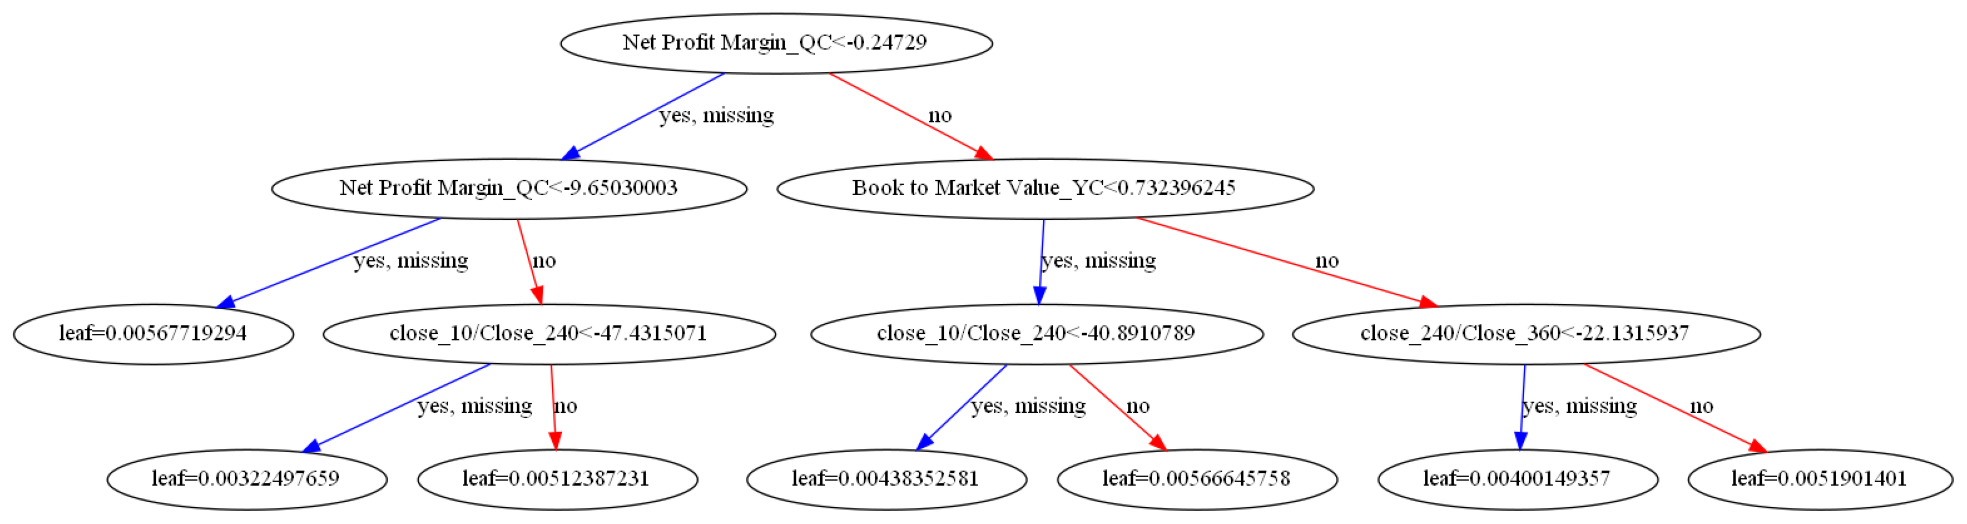

In [106]:
fig, ax = plt.subplots(figsize=(35, 10))  # whatever size you want
xgboost.plot_tree(bst, num_trees = 19, ax=ax)
plt.show()

In [ ]:
xgb.train({'tree_method': 'hist', 'seed': 1994},  # any other tree method is fine.
           dtrain=dtrain,
           num_boost_round=10,
           obj=squared_log)

In [83]:
params2 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  #'objective': 'binary:logistic',
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0,
    "eval_metric" : "logloss"
}

In [88]:
b = {}

In [91]:
bst = xgboost.train(params = params2, dtrain= xgtrain, num_boost_round = 2, evals = [(xgtest, "eval_logloss")], evals_result = b, obj = squared_log)

[0]	eval_logloss-logloss:0.18488
[1]	eval_logloss-logloss:1.69751


In [92]:
a

[array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5], dtype=float32),
 array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5], dtype=float32),
 array([0.9406395 , 0.91919374, 0.9340749 , ..., 0.90725744, 0.9242466 ,
        0.8834111 ], dtype=float32)]

In [53]:
grad = gradient(bst.predict(xgtrain), xgtrain)

In [71]:
xgtrain.get_label()

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [ ]:
def gradient(predt: np.ndarray, dtrain: xgboost.DMatrix):
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (y - predt)

def hessian(predt: np.ndarray, dtrain: xgboost.DMatrix):
    '''Compute the hessian for squared log error.'''
    #y = dtrain.get_label()
    return -predt * (1-predt)




In [87]:
def squared_log(predt: np.ndarray, dtrain: xgboost.DMatrix):
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    a.append(predt)
    
    labels = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = predt - labels
    hess = predt * (1 - predt)
    

    return grad, hess

In [ ]:
def squared_log(predt: np.ndarray, dtrain: xgboost.DMatrix):
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    
    labels = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = predt - labels
    hess = predt * (1 - predt)
    

    return grad, hess

In [86]:
a = []

In [58]:
def gradient(predt: np.ndarray, dtrain: xgboost.DMatrix):
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgboost.DMatrix):
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt: np.ndarray,dtrain: xgboost.DMatrix):
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [ ]:
weights = np.ones(len())

In [133]:
threshold_5 = np.percentile(predictions, 5)

In [136]:
start_time = time.perf_counter()
np.where((labels == 1) & (predictions < threshold_5))
print(time.perf_counter() - start_time)

0.0004568999993352918


In [138]:
np.where((labels == 1) & (predictions < threshold_5))[0]

array([    2,    32,    62, ..., 29148, 29167, 29175], dtype=int64)

In [131]:
predictions = bst.predict(xgtest)

In [119]:
labels = xgtest.get_label()

In [123]:
weights = np.ones(len(labels))

In [140]:
weights[np.where((labels == 1) & (predictions < threshold_5))[0]] = 100

In [141]:
weights[np.where((labels == 1) & (predictions < threshold_5))[0]]

array([100., 100., 100., ..., 100., 100., 100.])

In [126]:
len(labels)

29179

In [125]:
len(weights)

29179